# Multiclass classifiers TCGA
This notebook performs multiclass classification prediction of mutation variant types of the TP53 protein in TCGA samples

In [75]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest


### Data manipulation

In [76]:
genes_and_mutations = pd.read_csv('data/final_dataset_TCGA_cleaned.csv')
genes_and_mutations.shape

(1566, 20525)

In [77]:
patients = genes_and_mutations['Tumor_Sample_Barcode']
tp53= genes_and_mutations['is_tp53']
variants = genes_and_mutations['Variant_Type']
hugo_symbol = genes_and_mutations['Hugo_Symbol']
classifications = genes_and_mutations['Variant_Classification']
# Drop the columns that are not needed for the analysis so basically consider only the gene expression data
mod_data = genes_and_mutations.drop(columns=['Tumor_Sample_Barcode', 'is_tp53','Variant_Type','Hugo_Symbol','Variant_Classification'])

In [78]:
def detect_and_handle_outliers_isolation_forest(data, contamination=0.05, random_state=42, tp53_vec=None,variants_vec=None):
    # Create a copy of the data
    df = data.copy()
    
    # Select only numeric columns for outlier detection
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    X = df[numeric_cols].values
    
    # Fit the Isolation Forest model
    print(f"Fitting Isolation Forest with contamination={contamination}...")
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state, n_jobs=-1)
    outlier_predictions = iso_forest.fit_predict(X)
    
    # Find indices of outliers (outlier_predictions == -1)
    outlier_indices = np.where(outlier_predictions == -1)[0]
    outlier_count = len(outlier_indices)
    
    print(f"Detected {outlier_count} outliers ({outlier_count/len(df)*100:.2f}% of the data)")
    # If there are outliers, examine their characteristics
    if outlier_count > 0:
        # Compare the distribution of normal vs outlier samples
        final_df= df.drop(outlier_indices)
        tp53_vec = tp53_vec.drop(outlier_indices)
        variants_vec = variants_vec.drop(outlier_indices)
    return final_df, outlier_indices, tp53_vec, variants_vec

In [79]:
mod_data, outlier_indices, tp53,variants= detect_and_handle_outliers_isolation_forest(
        mod_data,
        contamination=0.05,
        tp53_vec=tp53,
        variants_vec=variants
    )

Fitting Isolation Forest with contamination=0.05...
Detected 79 outliers (5.04% of the data)


In [80]:
#map the values of the 'VariantType' column to integers
variants = variants.astype('category')
# Convert the 'VariantType' column to categorical
category_mapping = dict(enumerate(variants.cat.categories))
print(category_mapping)
variants = variants.cat.codes

{0: 'DEL', 1: 'INS', 2: 'SNP'}


In [81]:
#let's create the target column with the mapping seen above and the number 3 indicating that the mutation is not tp53
#we create a smaller dataset to do it with just the columns we need for practicality
# Explicitly name the columns after concatenation

binary_and_multi = pd.concat([tp53, variants], axis=1)
binary_and_multi.columns = ['is_tp53', 'Variant_Type']

multi_classes = []
for index, row in binary_and_multi.iterrows():
    if row['is_tp53'] == 1:
        multi_classes.append(row['Variant_Type'])
    else:
        # Number three will indicate that tp53 is not mutated
        multi_classes.append(3)

binary_and_multi['multi_classes'] = multi_classes

# This is the target column
multi_classes = binary_and_multi['multi_classes']

In [82]:
binary_and_multi

,is_tp53,Variant_Type,multi_classes
0,0,2,3
1,0,2,3
2,0,2,3
3,0,2,3
4,0,2,3
...,...,...,...
1559,1,2,2
1560,1,2,2
1562,0,2,3
1563,0,2,3


### Let's try to perform a PCA analysis to see if we are able to grasp some insights

In [83]:
# Prepare data for PCA
pca_input = mod_data
scaler = StandardScaler()
pca_input = scaler.fit_transform(pca_input)

# Run PCA
pca = PCA(n_components=128)
pca_result = pca.fit_transform(pca_input)

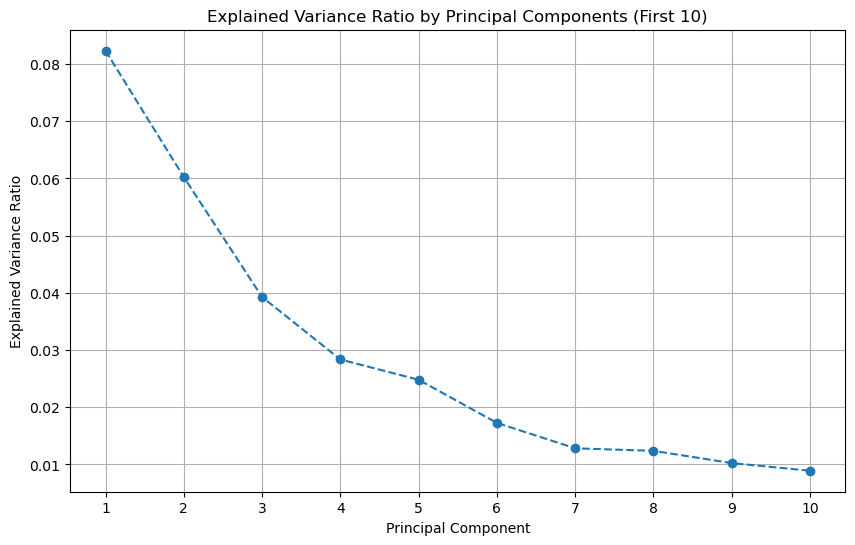

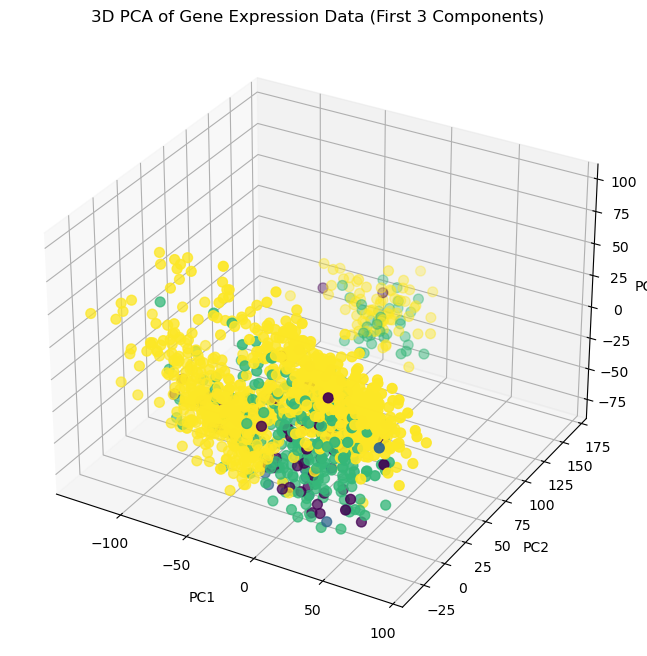

In [84]:
# plot the explained variance ratio for the first 10 components
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), pca.explained_variance_ratio_[:10], marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Principal Components (First 10)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, 11))
plt.grid()
plt.show()

# Convert PCA result to a DataFrame for easier handling
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
c = y.astype('category').cat.codes
# plot the PCA results in 3D using the first three principal components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],c=multi_classes , cmap='viridis', s=50)
ax.set_xlabel('PC1')

ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('3D PCA of Gene Expression Data (First 3 Components)')
plt.show()

### No particular clusterization emerges, the only thing we can say is that the first components are the most important as they possess the most variance

### Given the analysis done for the binary classification task we can do the same filtration of the columns and proceed with the classification task

In [85]:

genes_to_filter = [
    'CDKN1A', 'ABCA12', 'NTPCR', 'PGPEP1', 'RNF19B', 'LCE1E', 'EPN3', 'SCN4B', 'ARVCF', 'FCHO2', 'PANK2', 'TMEM8B',
    'RRM2B', 'ANKRA2', 'ORAI3', 'PLCL2', 'SAC3D1', 'LIMK2', 'FBXO32', 'SCRIB', 'BHLHE40', 'FCHSD2', 'PAQR7', 'TP53',
    'MDM2', 'CCNG1', 'PRKAB1', 'PMAIP1', 'SYTL1', 'LRP1', 'FHL2', 'SEMA3B', 'BMP7', 'FLRT2', 'PCBP4', 'TP53I11',
    'SUSD6', 'CYFIP2', 'PTP4A1', 'PRDM1', 'TNFRSF10A', 'MCC', 'HES2', 'SLC25A45', 'BORCS7', 'GBE1', 'PERP', 'TRAK1',
    'GDF15', 'DRAM1', 'SESN2', 'RAP2B', 'TNFRSF10D', 'NUPR1', 'KCNN4', 'SLC44A5', 'BTBD10', 'GPC1', 'PLLP', 'TRIP6',
    'BTG2', 'FBXO22', 'SLC30A1', 'RRAD', 'TSPAN11', 'PARD6G', 'KLHDC7A', 'SLC4A11', 'BTG3', 'HES1', 'POU3F1', 'TSGA10',
    'DDB2', 'ISCU', 'SPATA18', 'ZNF219', 'VWCE', 'PHPT1', 'LMNA', 'SLC9A1', 'C17orf89', 'HRAS', 'PPFIBP1', 'UNC5B',
    'GADD45A', 'PHLDA3', 'TGFA', 'ZNF337', 'DDIT4', 'PIDD1', 'MLF2', 'STAT3', 'CAPN2', 'HSD17B3', 'PPM1J', 'UQCC1',
    'PLK3', 'SERPINB5', 'TLR3', 'ACTA2', 'RAD51C', 'PML', 'MR1', 'STK17A', 'CASP6', 'ICOSLG', 'PPP4R3A', 'VDR',
    'TIGAR', 'SERTAD1', 'TM7SF3', 'EDN2', 'SERPINE1', 'PTPRE', 'MYO6', 'STX6', 'CATSPERG', 'IGFBP7', 'PTAFR', 'YPEL3',
    'RPS27L', 'TRAF4', 'TMEM68', 'ALOX5', 'TNFAIP8', 'PVRL4', 'NEFL', 'TP73', 'CAV1', 'IL1B', 'RALGDS', 'ZNF195',
    'TNFRSF10B', 'TRIM22', 'WDR63', 'ARHGEF3', 'TSKU', 'RETSAT', 'NKAIN4', 'TRIM32', 'CCNK', 'ISYNA1', 'RBM38', 'ZNF385A',
    'TRIAP1', 'CES2', 'ZNF561', 'CERS5', 'PCNA', 'REV3L', 'PCLO', 'TRIM38', 'CFLAR', 'JAG1', 'RGL1', 'ZNF488',
    'ZMAT3', 'CMBL', 'ZNF79', 'DDR1', 'ACYP2', 'RNASE7', 'PDE4C', 'TRIM5', 'CGB7', 'KRT8', 'RGS20',
    'BAX', 'FBXW7', 'ASCC3', 'DHRS3', 'APAF1', 'SFN', 'PGAP1', 'TYMSOS', 'CHST14', 'KSR1', 'RHOC',
    'PGF', 'HSPA4L', 'ACER2', 'DUSP14', 'APOBEC3H', 'TNFRSF10C', 'PLCXD2', 'AKAP9', 'COBLL1', 'LACC1', 'RPS19',
    'POLH', 'KITLG', 'ANXA4', 'E2F7', 'BCL2L1', 'TRIML2', 'PLEKHF1', 'CCDC51', 'CPEB2', 'LPXN', 'SARS',
    'PPM1D', 'SLC12A4', 'APOBEC3C', 'EPS8L2', 'BCL6', 'VCAN', 'PLTP', 'CDH8', 'CPSF4', 'LRPAP1', 'SCIN',
    'SULF2', 'ATF3', 'ASTN2', 'FAM210B', 'BLCAP', 'ADCK3', 'PLXNB1', 'DUSP11', 'DNAJB2', 'MFAP3L', 'SCN3B',
    'XPC', 'BBC3', 'CD82', 'GLS2', 'C17orf82', 'AK3', 'PLXNB2', 'GCC2', 'DOCK8', 'MKNK2', 'SDC4',
    'AEN', 'CCDC90B', 'CDIP1', 'GPX1', 'COL7A1', 'ALDH1A3', 'PRKAB2', 'METTL8', 'DUSP5', 'MON2', 'SDPR',
    'BLOC1S2', 'DYRK3', 'CPE', 'GRHL3', 'CPEB4', 'BBS2', 'PRKX', 'PPP1R3C', 'DUSP7', 'MRPL49', 'SMAD3',
    'FAS', 'EDA2R', 'CSF1', 'HHAT', 'CSNK1G1', 'BTG1', 'PRODH', 'STEAP3', 'EBI3', 'MYBPHL', 'SNX2',
    'GPR87', 'EPHA2', 'DCP1B', 'IGDCC4', 'DGKA', 'CEL', 'PTPRU', 'ABHD4', 'EFNB1', 'MYLK', 'SOCS4',
    'NINJ1', 'FAM13C', 'ENC1', 'IKBIP', 'FAM49A', 'CLCA2', 'RGMA', 'ABTB2', 'EI24', 'MYOF', 'TAB3',
    'PLK2', 'FAM198B', 'FOSL1', 'LAPTM5', 'FAM84B', 'CLDN1', 'RGS16', 'ADGRG1', 'EML2', 'NFKBIA', 'TCAIM',
    'PSTPIP2', 'FAM212B', 'FUCA1', 'MAST4', 'GNAI1', 'CLP1', 'RND3', 'AIFM2', 'ENPP2', 'NHLH2', 'TEP1',
    'SESN1', 'FDXR', 'IER5', 'MICALL1', 'INPP1', 'CROT', 'RNF144B', 'AMOTL1', 'ETV7', 'NLRP1', 'TET2',
    'TP53I3', 'LIF', 'PADI4', 'NOTCH1', 'ITGA3', 'CYP4F3', 'S100A2', 'AMZ2', 'FAM196A', 'NYNRIN', 'TEX9',
    'TP53INP1', 'NADSYN1', 'PANK1', 'RABGGTA', 'KRT15', 'DAPK1', 'SCN2A', 'ARC', 'FAM98C', 'P3H2', 'TMEM63B'
]

mod_data = mod_data[mod_data.columns[mod_data.columns.isin(genes_to_filter)]]

In [86]:
mod_data.shape

(1487, 326)

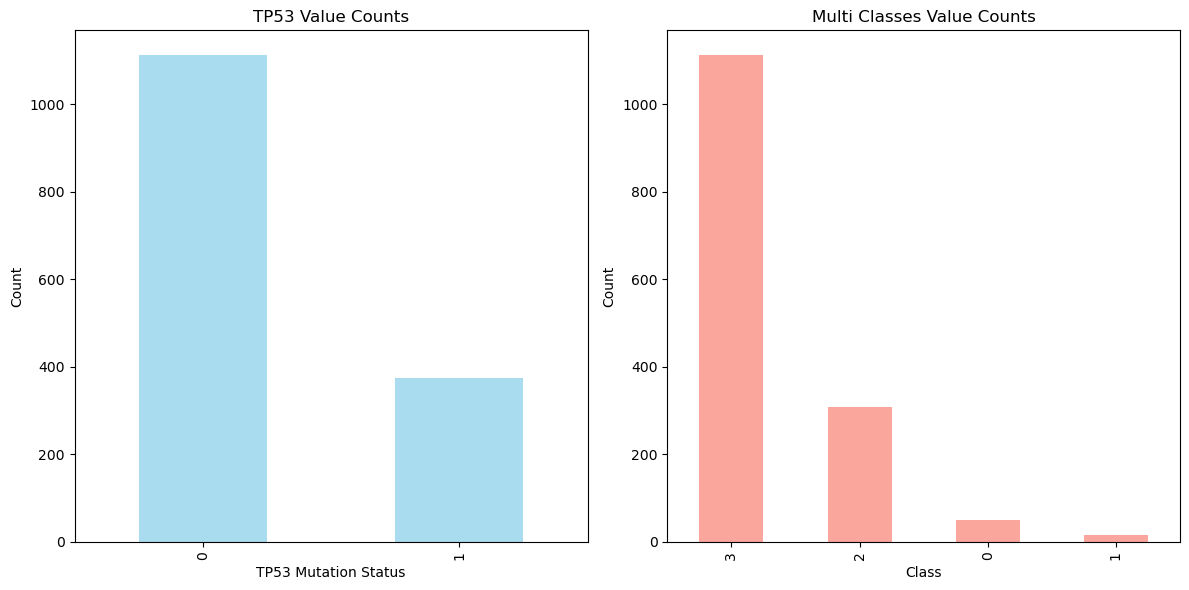

In [87]:

# Plot the value counts of tp53 and multi_classes as a bar chart
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for tp53
tp53.value_counts().plot(kind='bar', ax=axes[0], color='skyblue', alpha=0.7)
axes[0].set_title('TP53 Value Counts')
axes[0].set_xlabel('TP53 Mutation Status')
axes[0].set_ylabel('Count')

# Bar chart for multi_classes
multi_classes.value_counts().plot(kind='bar', ax=axes[1], color='salmon', alpha=0.7)
axes[1].set_title('Multi Classes Value Counts')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()
#

### The distribution of the classes is unbalanced towards the first two classes therefore we resort to oversampling.

In [88]:
X=mod_data
y = multi_classes
smote = SMOTE(random_state=42, sampling_strategy='auto')
X, y = smote.fit_resample(X, y)
# adasyn = ADASYN(random_state=42)
# X, y = adasyn.fit_resample(X, y)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### As first model we instantiate a Logistic Regression model

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       233
           1       0.99      1.00      1.00       204
           2       0.91      0.95      0.93       232
           3       0.97      0.89      0.92       222

    accuracy                           0.96       891
   macro avg       0.96      0.96      0.96       891
weighted avg       0.96      0.96      0.96       891



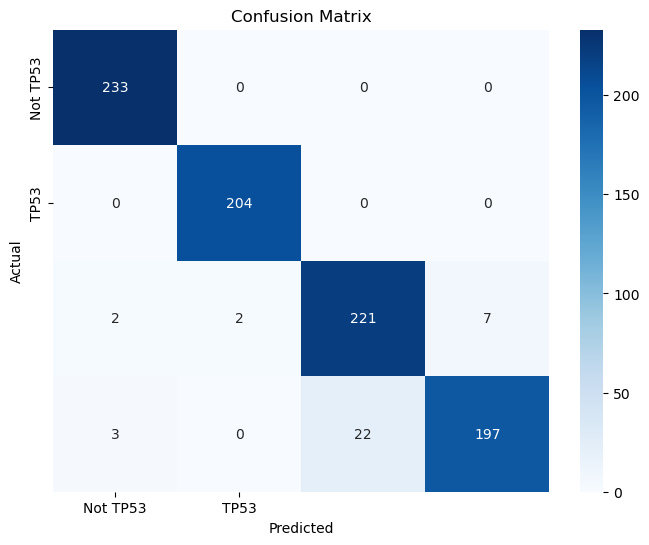

In [90]:
#fit the model
lg_model = LogisticRegression(max_iter=10000,random_state=42)
lg_model.fit(X_train, y_train)
#predict the test set
y_pred = lg_model.predict(X_test)
#predict the probabilities
y_pred_proba = lg_model.predict_proba(X_test)[:, 1]
#calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#calculate the classification report
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not TP53', 'TP53'], yticklabels=['Not TP53', 'TP53'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Then we proceed with a Random Forest classifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       233
           1       1.00      1.00      1.00       204
           2       0.97      0.97      0.97       232
           3       0.96      0.97      0.97       222

    accuracy                           0.98       891
   macro avg       0.98      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891



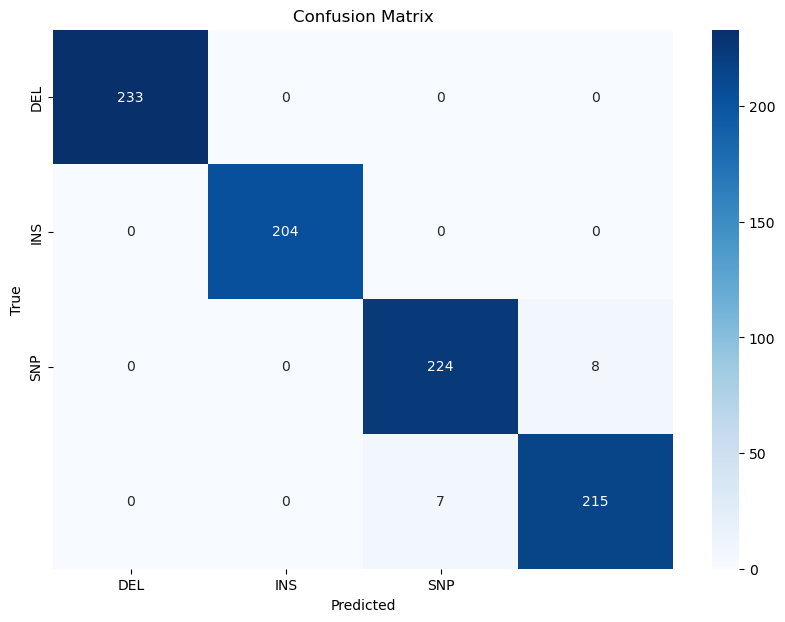

In [91]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

y_pred_proba = rf.predict_proba(X_test)
report = classification_report(y_test, y_pred)

print(report)
cm = confusion_matrix(y_test, y_pred)

#plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_mapping.values(), yticklabels=category_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Finally we proceed with XGboost

/Users/filippofocaccia/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:20:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       233
           1       0.99      1.00      1.00       204
           2       0.95      0.95      0.95       232
           3       0.98      0.95      0.97       222

    accuracy                           0.98       891
   macro avg       0.98      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891



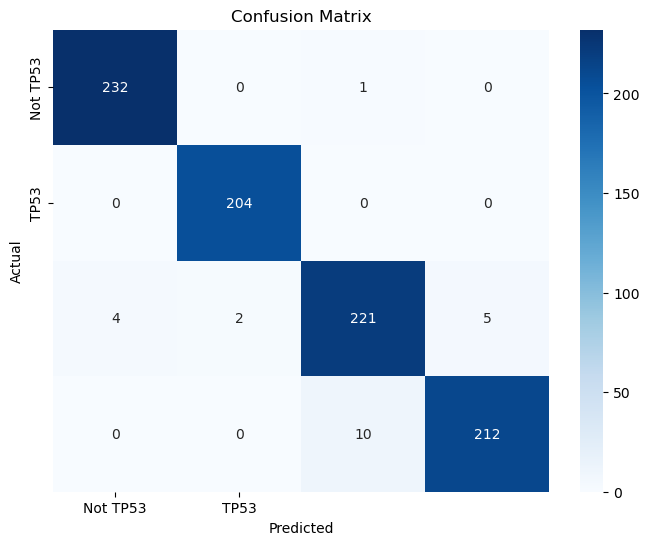

In [92]:
xgb_model = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, scale_pos_weight=1,random_state=42)
xgb_model.fit(X_train, y_train)
#predict the test set
y_pred = xgb_model.predict(X_test)
#predict the probabilities
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
#calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
#calculate the classification report
report = classification_report(y_test, y_pred)
print(report)
#calculate the roc_auc score
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not TP53', 'TP53'], yticklabels=['Not TP53', 'TP53'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

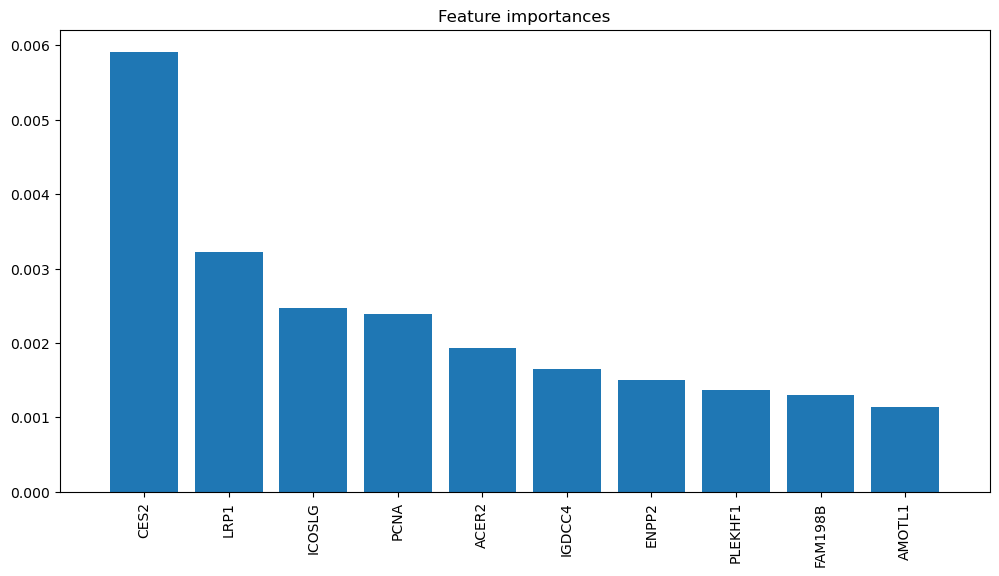

In [93]:
#feature importance
importances = (xgb_model.feature_importances_)[:10]
indices = np.argsort(importances)[::-1]
# Print the feature ranking
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), X_train.columns[indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.show()

- CES2 (highest importance): 
  Carboxylesterase 2 - An enzyme primarily involved in drug metabolism and detoxification of xenobiotics. Its prominence suggests different classes of TP53 mutations may distinctly affect detoxification pathways and potentially drug response mechanisms.

- LRP1: 
  Low-density lipoprotein Receptor-related Protein 1 - A multifunctional receptor involved in lipoprotein metabolism, endocytosis, and cell signaling. Different TP53 mutation classes may have distinct effects on cellular uptake processes and lipid metabolism.

- ICOSL/ICOSLG: 
  Inducible T-Cell Costimulator Ligand - A protein involved in T-cell activation and immune response regulation. This suggests different TP53 mutation classes may distinctly affect tumor-immune interactions.

- PCNA: 
  Proliferating Cell Nuclear Antigen - A critical protein for DNA replication and repair. TP53 directly regulates PCNA, and different mutation classes likely have varying impacts on genome maintenance mechanisms.

- ACER2: 
  Alkaline Ceramidase 2 - An enzyme involved in sphingolipid metabolism and ceramide signaling, which influences cell death pathways. Different TP53 mutation classes may distinctly affect stress response and apoptotic mechanisms.

- IGDCC4: 
  Immunoglobulin Superfamily DCC Subclass Member 4 - Involved in cell adhesion and neural development. Different TP53 mutation classes may distinctly affect cell-cell interactions.

- ENPP2: 
  Ectonucleotide Pyrophosphatase/Phosphodiesterase 2 (Autotaxin) - Produces lysophosphatidic acid (LPA), promoting cell proliferation and migration. Different TP53 mutation classes may have varying effects on lipid signaling pathways.

- PLEKHF1: 
  Pleckstrin Homology And FYVE Domain Containing 1 - Involved in endosome function and apoptosis regulation. This reinforces the distinct effects of different TP53 mutation classes on cell death mechanisms.

- FAM158B/TONSL: 
  TON1-regulatory protein 2 - Involved in DNA replication and repair. Along with PCNA, this highlights how different TP53 mutation classes distinctly affect genome stability.

- AMOTL1: 
  Angiomotin Like 1 - Regulates cell migration and proliferation through the Hippo pathway. Different TP53 mutation classes may distinctly affect cell growth control mechanisms.

Biological interpretation of this plot:

The predominance of CES2 is intriguing, suggesting drug metabolism pathways may be a key distinguishing feature between different TP53 mutation classes. This could have implications for differential treatment responses based on specific TP53 mutation types.
This diversity reflects how mutations in different domains or regions of TP53 can lead to distinct molecular phenotypes, potentially explaining why certain TP53 mutations confer different clinical behaviors in cancers.
The prominence of metabolism-related genes (CES2, LRP1, ACER2, ENPP2) suggests metabolic reprogramming may be a key distinguishing feature between different TP53 mutation classes, which aligns with emerging understanding of how TP53 regulates cellular metabolism.